In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import display, Latex

In [3]:
def stock_simu(S, T, r, sigma, N, M, seed):
    dt = T / N
    np.random.seed(seed)  
    paths = np.zeros((N + 1, M))
    paths[0] = S

    for t in range(1, N + 1):
        Z = np.random.standard_normal(int(M/2))
        Z = np.concatenate((Z, -Z))
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def call(ST,K):
    return np.maximum(ST-K, 0)

def put(ST,K):
    return np.maximum(K-ST, 0)

def least_squares_MC(S, K, T, r, sigma, M, N, order, option='put', seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t]>=0
        reg = np.polyfit(stock_paths[t][in_the_money], exercise_values[t+1][in_the_money]*df, order)
        
        C = np.polyval(reg, stock_paths[t][in_the_money])
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df
    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5

Pricing Value
-----------------
Monte Carlo mean: 4.454
Monte Carlo std: 0.012


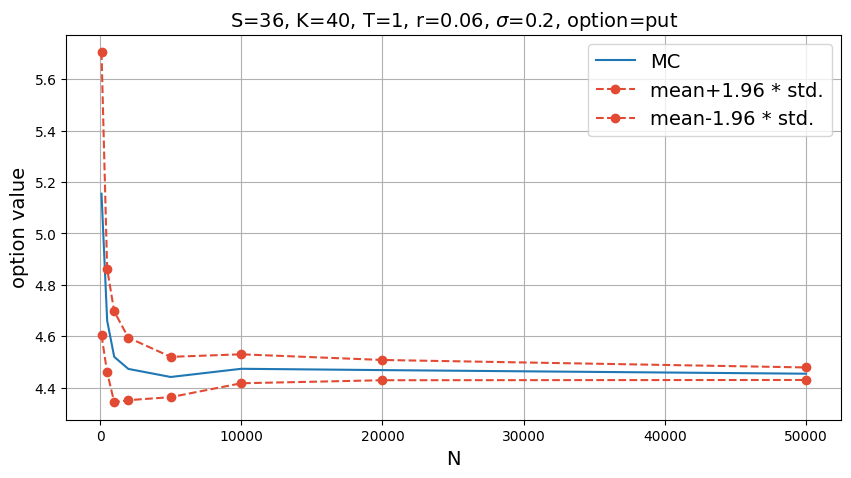

In [4]:
S = 36
K = 40
T = 1
r = 0.06
sigma = 0.2
N = 50
option = 'put'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r, sigma, n, N, 5)
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='MC')
plt.plot(M, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

### Compare with CRR

In [5]:
from CRR import *
from time import time

In [6]:
S = 36
K = 40
T = 1
r = 0.06
sigma = 0.2
option = 'put'
N = np.arange(1, 501, 50)
crr_res = []
jr_res = []
crr_time = []
jr_time = []
for n in N:
    t1 = time()
    crr = (binomial_tree(S, K, T, r, sigma, n, 'CRR', option, True))
    t2 = time()
    crr_res.append(crr)
    crr_time.append(t2-t1)

    t1 = time()
    jr = (binomial_tree(S, K, T, r, sigma, n, 'JR', option, True))
    t2 = time()
    jr_res.append(jr)
    jr_time.append(t2-t1)

M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
N = 50
mc_mean = []
mc_std = []
mc_time = []
for n in M:
    t1 = time()
    m, s = least_squares_MC(S, K, T, r, sigma, n, N, 5)
    t2 = time()
    mc_time.append(t2-t1)
    mc_mean.append(m)
    mc_std.append(s)

In [7]:
bin_res = pd.DataFrame({
    'N': np.arange(1, 501, 50),
    'CRR': crr_res,
    'CRR time': crr_time,
    'JR': jr_res,
    'JR time': jr_time,
})

lsmc_res = pd.DataFrame({
    'N': [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000],
    'LSMC': mc_mean,
    'LSMC time': mc_time
})

print('Binomial Tree')
print(bin_res.T)
print('============================================================================')
print('Least Square Monte Carlo')
print(lsmc_res.T)

Binomial Tree
                 0          1           2           3           4           5  \
N         1.000000  51.000000  101.000000  151.000000  201.000000  251.000000   
CRR       4.000000   4.491453    4.486619    4.486999    4.487295    4.487107   
CRR time  0.000055   0.003237    0.009804    0.021412    0.033523    0.065176   
JR        4.389952   4.490077    4.485555    4.487405    4.486585    4.486574   
JR time   0.000016   0.002384    0.009593    0.016352    0.032334    0.072585   

                   6           7           8           9  
N         301.000000  351.000000  401.000000  451.000000  
CRR         4.486139    4.487319    4.486657    4.486501  
CRR time    0.074550    0.088702    0.114431    0.161353  
JR          4.487165    4.487256    4.486819    4.486027  
JR time     0.063060    0.088312    0.113144    0.142841  
Least Square Monte Carlo
                    0           1            2            3            4  \
N          100.000000  500.000000  1000.0000